In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xarray as xr

# set plotly as default pandas plot

pd.options.plotting.backend = "plotly"

In [2]:
station = "Calcofi"

In [3]:
data = xr.load_dataset(f"../data/1_products/{station}_obs.zarr", engine="zarr")
data

<xarray.Dataset> Size: 353MB
Dimensions:    (time: 7796, latitude: 55, longitude: 103, layer: 1)
Coordinates:
  * latitude   (latitude) float64 440B 0.5 1.5 2.5 3.5 ... 51.5 52.5 53.5 54.5
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 824B -179.5 -178.5 -177.5 ... -78.5 -77.5
  * time       (time) datetime64[ns] 62kB 1951-01-09 1951-01-10 ... 2023-01-25
Data variables:
    day        (time, latitude, longitude, layer) float32 177MB nan nan ... nan
    night      (time, latitude, longitude, layer) float32 177MB nan nan ... nan

# Remove outliers


In [29]:
q1 = data.quantile(0.25, dim=["time", "latitude", "longitude"])
q3 = data.quantile(0.75, dim=["time", "latitude", "longitude"])
iqr = q3 - q1

In [30]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [31]:
new_data = data.where((data > lower_bound) & (data < upper_bound))

In [32]:
print("Original data")
print(f"Number of observation = {int(data.day.notnull().sum() + data.night.notnull().sum())}")
print(f"Number of observation in same place during same day = {int((data.day.notnull() & data.night.notnull()).sum())}")

print("\nWithout outliers")
print(f"Number of observation = {int(new_data.day.notnull().sum() + new_data.night.notnull().sum())}")
print(
    f"Number of observation in same place during same day = {int((new_data.day.notnull() & new_data.night.notnull()).sum())}"
)

print(
    f"\nTotal number of observation with more biomass during day = {int(((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum())}"
)

Original data
Number of observation = 33379
Number of observation in same place during same day = 5495

Without outliers
Number of observation = 30891
Number of observation in same place during same day = 4793

Total number of observation with more biomass during day = 1498


Text(0.5, 1.0, 'Number of days with day-night difference > 0')

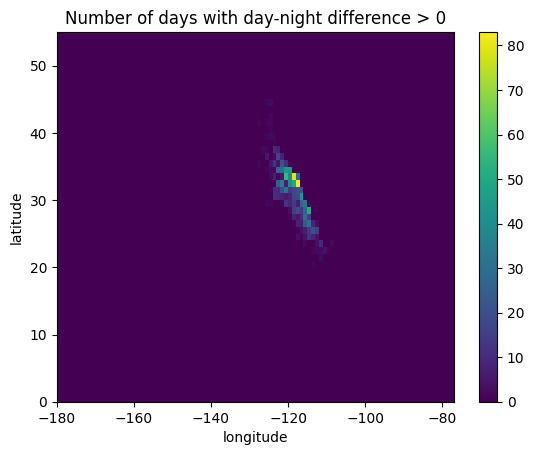

In [33]:
((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum(
    "time"
).plot()
plt.title("Number of days with day-night difference > 0")

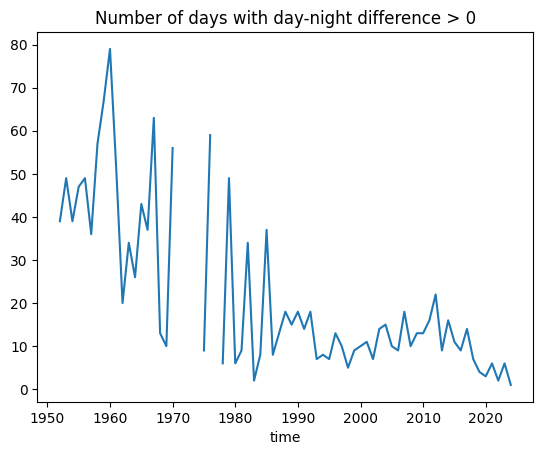

In [34]:
((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum(
    ["latitude", "longitude"]
).resample({"time": "1YE"}).sum().plot()
plt.title("Number of days with day-night difference > 0")
plt.show()

# Remove observations when day > night


In [35]:
# to_remove = new_data["day"].where(new_data["day"] > new_data["night"]).dropna("time").time
# new_data = new_data.drop_sel(time=to_remove)
# to_remove.to_series()

## DAY


In [36]:
pd.DataFrame(
    {
        "original": data.day.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
        "post-processed": new_data.day.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
    }
).plot(title="Day biomass observations", kind="scatter", opacity=0.5).update_traces(mode="lines+markers").update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m3)",
    title="Day biomass observations",
)

In [37]:
data_to_plot = pd.DataFrame(
    {
        "original": data.day.mean(["time"]).dropna("latitude", how="all").dropna("longitude", how="all").to_series(),
        "post-processed": new_data.day.mean(["time"])
        .dropna("latitude", how="all")
        .dropna("longitude", how="all")
        .to_series(),
    }
)

figure = px.scatter_3d(data_to_plot.reset_index(), x="longitude", y="latitude", z="original", title="Day observations")

figure.add_scatter3d(
    x=data_to_plot.reset_index().longitude,
    y=data_to_plot.reset_index().latitude,
    z=data_to_plot["post-processed"],
    mode="markers",
    name="post-processed",
)

figure.update_traces(marker={"size": 0}).update_layout(
    scene={
        "xaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "yaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "aspectmode": "manual",
        "aspectratio": {"x": 2, "y": 1, "z": 0.5},
        "camera": {"eye": {"x": 0.80, "y": 0.80, "z": 0.80}},
    },
    title=f"{station} mean biomass over time : Day",
    height=600,
)

## NIGHT


In [38]:
pd.DataFrame(
    {
        "original": data.night.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
        "post-processed": new_data.night.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
    }
).plot(title="Day observations", kind="scatter", opacity=0.5).update_traces(mode="lines+markers").update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m3)",
    title="Night biomass observations",
)

In [39]:
data_to_plot = pd.DataFrame(
    {
        "original": data.night.mean(["time"]).dropna("latitude", how="all").dropna("longitude", how="all").to_series(),
        "post-processed": new_data.night.mean(["time"])
        .dropna("latitude", how="all")
        .dropna("longitude", how="all")
        .to_series(),
    }
)

figure = px.scatter_3d(data_to_plot.reset_index(), x="longitude", y="latitude", z="original", title="Day observations")

figure.add_scatter3d(
    x=data_to_plot.reset_index().longitude,
    y=data_to_plot.reset_index().latitude,
    z=data_to_plot["post-processed"],
    mode="markers",
    name="post-processed",
)

figure.update_traces(marker={"size": 0}).update_layout(
    scene={
        "xaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "yaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "aspectmode": "manual",
        "aspectratio": {"x": 2, "y": 1, "z": 0.5},
        "camera": {"eye": {"x": 0.80, "y": 0.80, "z": 0.80}},
    },
    title=f"{station} mean biomass over time : Night",
    height=500,
)

# Export


In [40]:
new_data.to_zarr(f"../data/1_products/{station}_obs_filtered.zarr", mode="w")